In [299]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

1. Perform classification on FashionMNIST, fashion apparels dataset, using a pre-
trained model which is trained on MNIST handwritten digit classification dataset.

In [300]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [301]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [302]:
train_dataset = datasets.MNIST(root='/home/student/220962137_DL/Lab5/data', train=True, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [303]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [304]:
model = MNISTCNN()
model.to(device)

MNISTCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [305]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

torch.save(model,"./model.pt")
torch.save(model.state_dict(), "./state_dict.pt")

Epoch [1/5], Loss: 0.2660
Epoch [2/5], Loss: 0.0768
Epoch [3/5], Loss: 0.0580
Epoch [4/5], Loss: 0.0493
Epoch [5/5], Loss: 0.0419


In [306]:
model=MNISTCNN()
model.load_state_dict(torch.load("./state_dict.pt"))

model.to(device)

MNISTCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [307]:
train_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform = transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform = transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

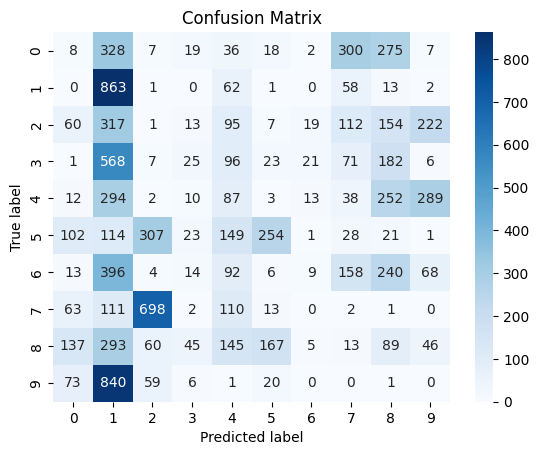

Accuracy: 13.38%


In [308]:
def evaluate_model(loader, model):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total

    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
        
    return accuracy

accuracy=evaluate_model(test_loader,model)
print(f"Accuracy: {accuracy:.2f}%")

3. Implement check points in PyTorch by saving model state_dict, optimizer state_dict, epochs
and loss during training so that the training can be resumed at a later point. Also, illustrate
the use of check point to save the best found parameters during training.

In [309]:
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}, loss {loss:.4f}")

In [310]:
def load_checkpoint(model, optimizer, checkpoint_path='checkpoint.pth'):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Checkpoint loaded from epoch {epoch}, loss {loss:.4f}")
        return model, optimizer, epoch, loss
    else:
        print("No checkpoint found, starting fresh.")
        return model, optimizer, 0, None

In [311]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
best_loss = float('inf')

model, optimizer, start_epoch, prev_loss = load_checkpoint(model, optimizer, 'checkpoint.pth')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    save_checkpoint(model, optimizer, epoch, avg_loss, 'checkpoint.pth')
    if avg_loss < best_loss:
        best_loss = avg_loss
        print(f"New best model found with loss {best_loss:.4f}. Saving the model.")
        torch.save(model.state_dict(), 'best_model.pth')
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

No checkpoint found, starting fresh.
Checkpoint saved at epoch 0, loss 1.5302
New best model found with loss 1.5302. Saving the model.
Epoch [1/5], Loss: 1.5302
Checkpoint saved at epoch 1, loss 0.6319
New best model found with loss 0.6319. Saving the model.
Epoch [2/5], Loss: 0.6319
Checkpoint saved at epoch 2, loss 0.4993
New best model found with loss 0.4993. Saving the model.
Epoch [3/5], Loss: 0.4993
Checkpoint saved at epoch 3, loss 0.4359
New best model found with loss 0.4359. Saving the model.
Epoch [4/5], Loss: 0.4359
Checkpoint saved at epoch 4, loss 0.3974
New best model found with loss 0.3974. Saving the model.
Epoch [5/5], Loss: 0.3974


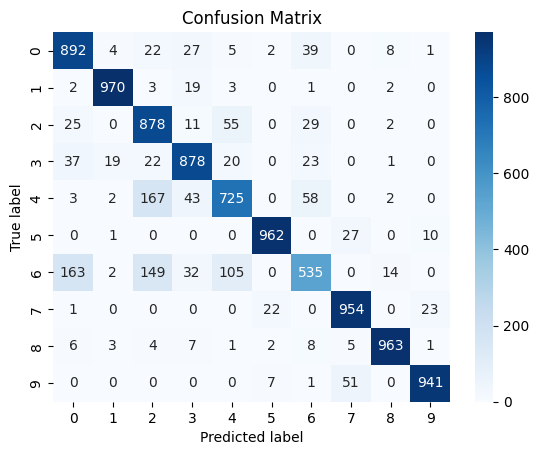

Accuracy: 86.98%


In [312]:
accuracy=evaluate_model(test_loader,model)
print(f"Accuracy: {accuracy:.2f}%")

2. Learn the AlexNet architecture and apply transfer learning to perform the classification
task. Using the pre-trained AlexNet, classify images from the cats_and_dogs_filtered
dataset downloaded from the below link. Finetune the classifier given in AlexNet as a two-
class classifier. Perform pre-processing of images as per the requirement.

In [313]:
model=models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

model = model.to(device)

In [314]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [315]:
val_dataset=datasets.ImageFolder("./cats_and_dogs_filtered/val",transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

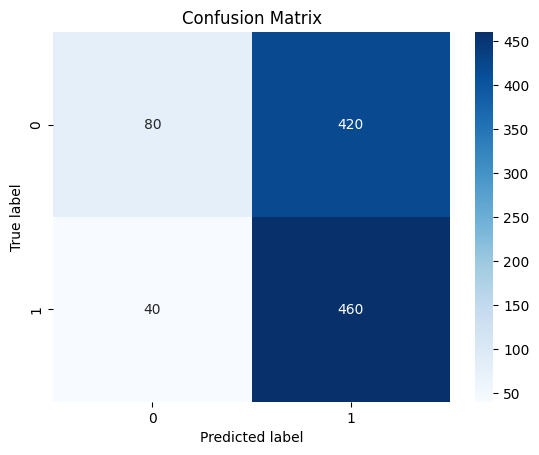

Accuracy: 54.00%


In [316]:
accuracy = evaluate_model(val_loader, model)
print(f"Accuracy: {accuracy:.2f}%")